In [75]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import seaborn as sns
import numpy as np
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

# A notebook for reviewing sentiment analysis output.
For the sentiment models see: core/analysis/sentiment_analysis/

- textblob: BQ_td_sentiment_textblob.ipynb
- vader: vader_sentiment_analysis_june_july.ipynb

## Read sentiment scores

In [2]:
# Vader scores
processed_scores_columns = pd.read_pickle("../../all_sentiment_vader.pkl")
processed_scores_columns.head()

,vader_neg,vader_neu,vader_pos,vader_compound
0,0.229,0.654,0.118,-0.4019
1,0.000,0.928,0.072,0.1027
2,0.000,1.000,0.000,0.0000
3,0.000,1.000,0.000,0.0000
4,0.189,0.811,0.000,-0.2732


In [3]:
# text blob scores
posts_file_path = os.path.join('..','..', "textblob_cleaned_sentiment.pkl")
pick_op = open(posts_file_path, 'rb')
textblob_df = pickle.load(pick_op)
textblob_df.rename(columns = {'sentiment':'textblob_sentiment', 'objectivity':'textblob_objectivity'}, inplace = True)
textblob_df.head()

,textblob_sentiment,textblob_objectivity
0,-0.200000,0.300000
1,0.000000,0.500000
2,0.000000,0.000000
3,-0.155556,0.288889
4,0.000000,0.000000


## Read input text and concat to sentiment scores

In [4]:
# data = pd.read_pickle("../../../sampled_processed_extant_posts.pkl")
data = pd.read_pickle("../../../all_clean_str_extant_posts.pkl")

In [5]:
data.head(5)

,orig_selftext,text_clean_space,text_clean_punc_lower,len_clean
0,"Another one of their smug, preachy ass headlin...","Another one of their smug, preachy ass headlin...",another one of their smug preachy ass headline...,70
1,enema has been pretending to be a rapper for y...,enema has been pretending to be a rapper for y...,enema has been pretending to be a rapper for y...,105
2,That area from Abilene to border (I-20 to I-10...,That area from Abilene to border (I-20 to I-10...,that area from abilene to border i20 to i10 an...,92
3,She's got the politician fist point down,She's got the politician fist point down,shes got the politician fist point down,39
4,Imagine getting paid to drop three words on a ...,Imagine getting paid to drop three words on a ...,imagine getting paid to drop three words on a ...,62


In [6]:
data = pd.concat([data, processed_scores_columns, textblob_df],
                         axis='columns')

### Example output

In [7]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
data[['text_clean_space', 'vader_compound', 'textblob_sentiment', 'textblob_objectivity']].tail(10).sort_values(
    'vader_compound')

<ipython-input-7-41f36cc4b537>:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


,text_clean_space,vader_compound,textblob_sentiment,textblob_objectivity
10015585,"And because he wants to publicly reveal that theyve all been cheating off each other the whole time, fucking over everyone else in the process.",-0.5574,-0.065000,0.348333
10015578,I've said for over a year gram is a snake and bad for America. He's the one that pushed for red flag laws.,-0.5423,-0.350000,0.333333
10015579,Just when we thought the dirty Sanchez was an internet myth,-0.4404,-0.600000,0.800000
10015577,But But But... MUH QUID PRO QUO!!!! REEEEEEEEEEEEEEEEEEE,0.0000,0.000000,0.000000
10015584,"I also think historically speaking the impeachment will be a stain on the Democrats record, not the President's.",0.0000,0.000000,0.000000
10015582,Yawn. Hope it fails.,0.0258,-0.500000,0.300000
10015580,[That sounds like something Mao Zedong would say!](https://en.wikipedia.org/wiki/Political_power_grows_out_of_the_barrel_of_a_gun),0.4199,0.000000,0.000000
10015583,"EVERY single vote counts. We need to bury their ""popular vote"" narrative six feet deep.",0.4215,0.176190,0.504762
10015581,"Our coat bot is back, yay!",0.5707,0.000000,0.000000
10015576,"Rule2 Never go outside the expertise of your people. It results in confusion, fear and retreat. Feeling secure adds to the backbone of anyone. Rule6 A good tactic is one your people enjoy. **Theyll keep doing it without urging** and come back to do more. Theyre doing their thing, and will even suggest better ones. Rule8 Keep the pressure on. Never let up. **Keep trying new things to keep the opposition off balance**. As the opposition masters one approach, hit them from the flank with something new. Rule10 The major premise for tactics is the development of operations that will **maintain a constant pressure upon the opposition**. It is this unceasing pressure that results in the reactions from the opposition that are essential for the success of the campaign.",0.7506,0.241171,0.368648


(0.0, 5500000.0)

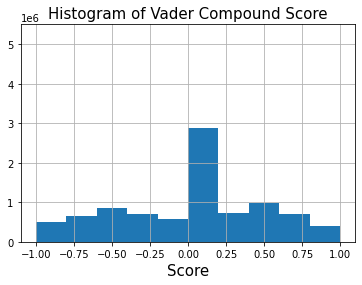

In [8]:
data.hist(column="vader_compound")
plt.xlabel("Score", size=15)
plt.title("Histogram of Vader Compound Score", size=15)
plt.ylim([0, 5500000])

(0.0, 5500000.0)

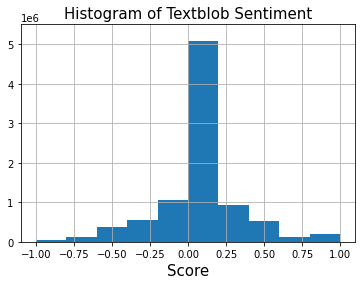

In [9]:
data.hist(column="textblob_sentiment")
plt.xlabel("Score", size=15)
plt.title("Histogram of Textblob Sentiment", size=15)
plt.ylim([0, 5500000])

## Temporal analysis

### Join to full data to get date column

In [10]:
posts_pkl_path = os.path.join('..', '..', '..', "combined_bigquery_processed.pkl")
posts_df = pd.read_pickle(posts_pkl_path)

In [11]:
data = data.merge(posts_df, left_index = True, right_index = True, how = 'left')

In [12]:
data['date'] = pd.to_datetime(data['created_date'], format='%Y-%m-%d')
data['date'] = data['date'].dt.date

In [51]:
data = data[data['author']!='AutoModerator']

In [52]:
def plot_seven_day_moving_avg(df, col, title, y_axis, counts=False):
    
    if counts:
        compound_date = df.groupby(['date'])[col].size().reset_index()
        compound_date.set_index('date', inplace=True)
    else:
        compound_date = df.groupby(['date'])[col].mean().reset_index()
        compound_date.set_index('date', inplace=True)
    
    MOVING_AVG_WINDOW = 7
    compound_date['7_day_avg'] = (compound_date[col].
            rolling(window=MOVING_AVG_WINDOW).mean())
    
    plt.figure(figsize=(20,6))
    ax = compound_date['7_day_avg'].plot(linewidth=0.5)
    plt.ylabel(y_axis, size=15)
    plt.xlabel("Date", size=15)
    plt.title(title, size=18)
    # Major ticks every month.
    fmt_month = mdates.MonthLocator()
    ax.xaxis.set_major_locator(fmt_month)

    plt.axvline(dt.datetime(2019, 6, 26))

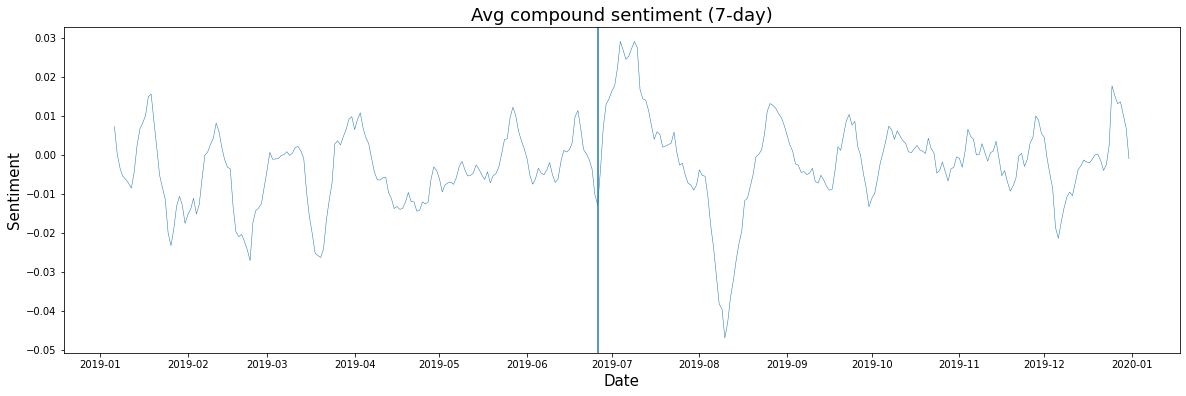

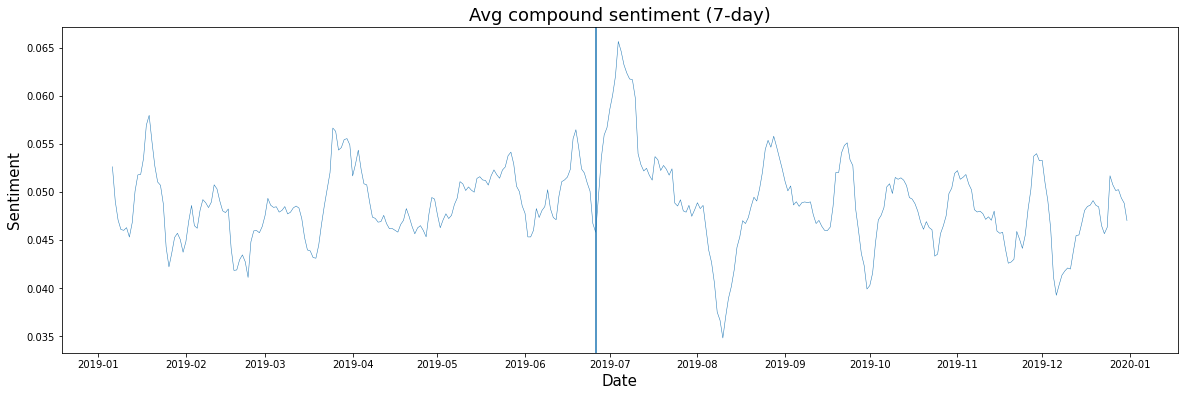

In [53]:
plot_seven_day_moving_avg(data, 'vader_compound', 'Avg compound sentiment (7-day)', 'Sentiment')
plot_seven_day_moving_avg(data, 'textblob_sentiment', 'Avg compound sentiment (7-day)', 'Sentiment')

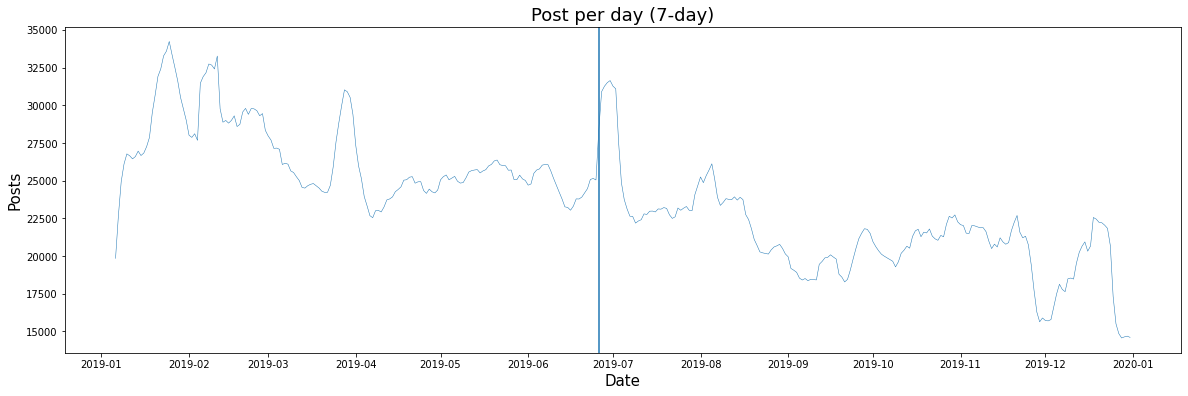

In [54]:
plot_seven_day_moving_avg(data, 'vader_compound', 'Post per day (7-day)', 'Posts', True)

In [78]:
def plot_seven_day_moving_avg_overlap(df):
    
    compound_date = df.groupby(['date'])['vader_compound'].mean().reset_index()
    compound_date.set_index('date', inplace=True)
    
    compound_date2 = df.groupby(['date'])['textblob_sentiment'].mean().reset_index()
    compound_date2.set_index('date', inplace=True)
    
    MOVING_AVG_WINDOW = 7
    compound_date['7_day_avg_vader'] = (compound_date['vader_compound'].
            rolling(window=MOVING_AVG_WINDOW).mean())
    
    compound_date2['7_day_avg_textblob'] = (compound_date2['textblob_sentiment'].
        rolling(window=MOVING_AVG_WINDOW).mean())
    
    plt.figure(figsize=(20,8))
    ax = compound_date['7_day_avg_vader'].plot(linewidth=1.5)
    ax2 = compound_date2['7_day_avg_textblob'].plot(linewidth=1.5)
    plt.ylabel("Score", size=15)
    plt.xlabel("Date", size=15)
    plt.title("Sentiment over time", size=20)
    # Major ticks every month.
    fmt_month = mdates.MonthLocator()
    ax.xaxis.set_major_locator(fmt_month)
    plt.axvline(dt.datetime(2019, 6, 26), color="red")
    plt.axvline(dt.datetime(2019, 7, 10), color="red")
    plt.axvline(dt.datetime(2019, 8, 10), color="purple")
    ax.legend()
    plt.legend(fontsize=20)

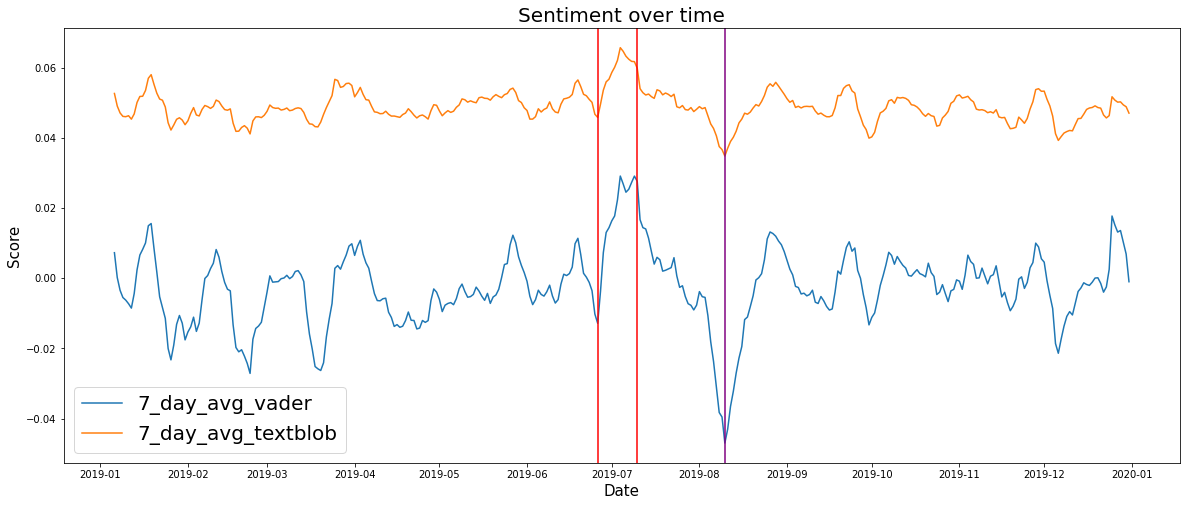

In [79]:
plot_seven_day_moving_avg_overlap(data)

### Look at data for interesting dates

In [57]:
subset_date = data[(data['date']>= datetime.strptime('2019-06-25', '%Y-%m-%d').date())
     & (data['date']<= datetime.strptime('2019-06-27', '%Y-%m-%d').date())]

In [58]:
subset_date[['date','orig_selftext',
             'vader_compound',
             'textblob_sentiment',
             'textblob_objectivity']].sample(n=50).sort_values('date')

,date,orig_selftext,vader_compound,textblob_sentiment,textblob_objectivity
3888630,2019-06-25,"In equally important news, why the fuck do drones cost $130 million?",-0.4019,0.000000,0.800000
3781196,2019-06-25,No. They were indentured servants which are different than slaves. They had way more rights. Now stop spreading misinformation.,-0.7152,0.250000,0.550000
3440924,2019-06-25,"I actually care quite a lot about what kinds of non-western influences they have. Particularly now, considering they have Russian SAMs that were given to them by Russia, that have now cost us **135 MILLION** dollars because the unstable, literal shit-for-brains morons decided to fire it off and down one of our drones in INTERNATIONAL WATERS.\n\nYou don't care? Ok. I'd like to change your mind and tell you why you SHOULD care, however - I think it would be one of the worst decisions you could make to ignore Russia's use and funding of proxy nations to cause chaos and terror in the middle east, most often at our expense. \n\nSo yes, I care very much what kind of influences they have in the middle east, because it directly impacts us.",-0.5416,0.012222,0.377302
3643026,2019-06-25,"When the ""peaceful"" people just want to kidnap you and you have to defend yourself it's a very dark future indeed.\n\nI bet this article was written from the wrong perspective.",-0.4215,-0.111250,0.511250
3794644,2019-06-25,She actually sold her name a long time ago and didn't even control her own brand anymore.,0.0000,0.183333,0.500000
3729888,2019-06-25,She reminds me of Lisa Page.,0.0000,0.000000,0.000000
4216703,2019-06-25,Can someone please explain what we see?,0.3182,0.000000,0.000000
4001181,2019-06-25,You'll appreciate knowing that this dipshit's IMDB page has been a barren wasteland since his hoax crime was reported. Asshat Smollett's career and hirability is now radioactive.,-0.4404,0.000000,0.000000
4150073,2019-06-26,I know. Like that would stop any T_D user I know,0.0772,0.000000,0.000000
3608209,2019-06-26,washington needs an in n out bad,-0.5423,-0.700000,0.666667


In [59]:
subset_date2 = data[(data['date']>= datetime.strptime('2019-08-09', '%Y-%m-%d').date())
     & (data['date']<= datetime.strptime('2019-08-11', '%Y-%m-%d').date())]

In [73]:
subset_date2[['date','orig_selftext',
             'vader_compound',
             'textblob_sentiment',
             'textblob_objectivity']].sample(n=600).sort_values('vader_compound')[0:100]

,date,orig_selftext,vader_compound,textblob_sentiment,textblob_objectivity
8367392,2019-08-10,"Why did it take that initial attack when they had been calling for help and support for days/weeks as the situation clearly deteriorated? This thread isn’t criticizing the military for failing, but rather the state department who insisted on ignoring and blocking any calls for aid and then in the aftermath tried to blame a clearly devolving situation, pointed out by special forces experts on the ground, complete with narrowly surviving IED attacks... on a 4chan made racist cartoon YouTube video. The state department then tried to sell the narrative that a racist cartoon on YouTube generated a full scale military assault, which apparently had no prelude, by separate and cooperating enemy military forces working in conjunction to attack a US Embassy and kill a US ambassador. Seems... legit... All makes sense when you consider the democrats created a 2015-present campaign entirely built upon the notion that all wrongs/ills in the entire world today stem from racism on social media. Madam Secretary's response to her failure at DOS could actually be seen as a proto-campaign strategy.\n\nWell surely that’s ridiculous enough that we would strongly question the head of the state department. Oh whoops. It was she who cannot be questioned. “What difference does it make?” About several dead American service members and politicians laid at her feet. A response only she could angrily bark out in congress and get away with it. Meanwhile if you ran over a dog on accident and yelled at the jury “what difference does it make?” You’d be locked away in contempt. She really was, and is, so far above the law that the mere concept of answering for her actions doesn't even occur to her.\n\nI really wanted to see Epstein point the finger at her just to watch her not even deny it and ask ""So what, me and my husband rape kids... What difference does it make?"". But of course, nobody has dirt on them and lives. Even with 24/7 security on suicide watch.",-0.9975,0.005794,0.419233
8324869,2019-08-10,"I do remember that, thanks for reminding me. That also escalated to black people looting and destroying their own neighborhoods and the BLM people saying something like ""yall need to go into the suburbs and loot because we need our weaves"" lololol Bernie Sanders was shoved off his own stage by those thugs lmao... and we're to believe he can run this country? BLM also got a black cop shot when they incited the crowd another time.\n\nbut yeah, white people are the racist ones causing problems...give me a f'n break. Black people are destroying themselves with abortions or popping out babies with multiple fathers who don't have a clue how to to parent and just plain being dumb shits well enough on their own. They are holding themselves down, talking about ""you talk too much like an educated white person"" yet Memphis city schools was doing that ""no child left behind bs"" and automatically passing kids that weren't even coming to school regularly. While their thug friends were stealing copper out of the air conditioners on the roof so the kids had to be in the summer heat if they stayed in class. Then there's the thug rappers they idolize to the point they walk, talk, and want to be just like them based on music videos with money, drugs, cars and fat asses thrown around. Sure buddy, get that face/neck tattoo and see how many people give you a shot after you purposely make yourself look like a fool with your metal capped teeth and weed tattoos.\n\nRight now, my opinion is that black culture is fucked, they really need to get rid of this ""thug life"" mentality and stop blaming whitey for their self imposed retardation. Stop pulling the race card and start pulling your pants up.\n\nI'm so grateful that people like Candice Owen and Trump are being open about the problems in the black community. it won't get fixed EVER if we all pretend it's racist to talk about what we

# Evaluation on manual labels

In [21]:
def create_count_data(df, group):
    """
    create dataframe of counts based on groupby
    :param df: pandas dataframe
    :param group: name of column to groupby
    :return: dataframe of counts for each group
    """
    counts = df.groupby(group).size().to_frame('count')
    counts.reset_index(inplace=True)
    return counts

def create_barplot(count_data, grouped_by_col, count_col, title):
    """
    create bar plot based on grouped_by_col
    """
    plt.figure(figsize=(20,6))
    p = sns.barplot(x=grouped_by_col, y=count_col,
                data=count_data)
    p.set_xticklabels(p.get_xticklabels(), rotation=40, ha="right")
    plt.ylabel("Count", size=15)
    plt.xlabel(grouped_by_col, size=15)
    plt.title(title, size=18)
    plt.show()

### Read label data
There are two sets (two labelers)

In [22]:
labels_1 = pd.read_csv("set_1.csv", index_col=0)
labels_1.head()
labels_1 = labels_1[["label"]]
labels_1.head()

,label
3605270,neutral
3844737,neutral
4113392,negative
3035067,neutral
3038117,negative


      label  count
0  negative  199  
1  neutral   241  
2  positive  51   


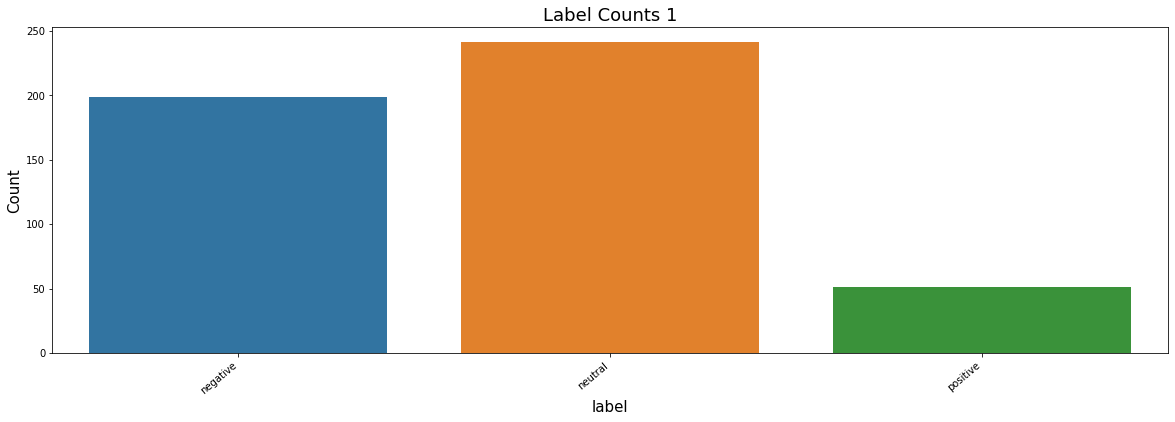

In [23]:
label_1_counts = create_count_data(labels_1, "label")
print(label_1_counts)
create_barplot(label_1_counts, "label", "count", "Label Counts 1")

In [24]:
labels_2 = pd.read_csv("set_3.csv", index_col=0)
labels_2.head()
labels_2 = labels_2[["label"]]
labels_2.head()

,label
2919497,0
3681067,1
2883915,-1
2579220,-1
3309177,0


   label  count
0 -1      128  
1  0      336  
2  1      36   


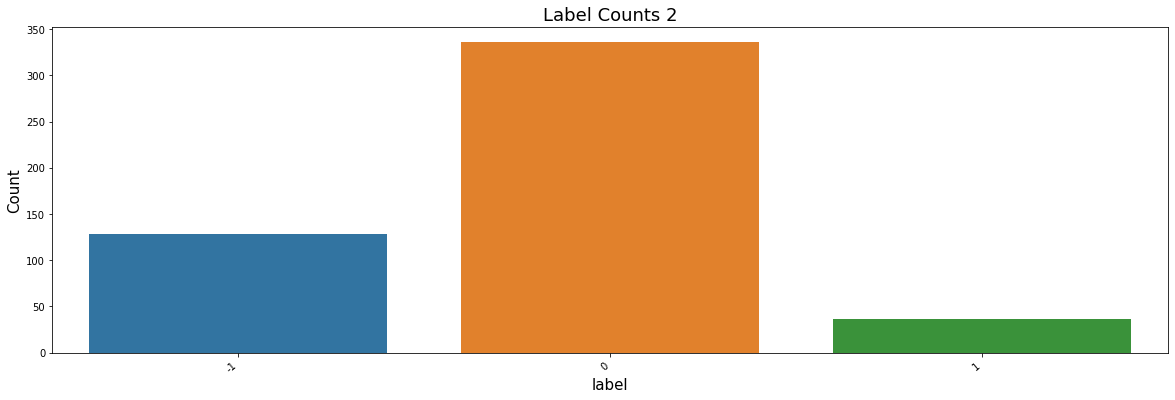

In [25]:
label_2_counts = create_count_data(labels_2, "label")
print(label_2_counts)
create_barplot(label_2_counts, "label", "count", "Label Counts 2")

In [26]:
labels_2["label"][labels_2["label"]==-1] = "negative"
labels_2["label"][labels_2["label"]==0] = "neutral"
labels_2["label"][labels_2["label"]==1] = "positive"

      label  count
0  negative  128  
1  neutral   336  
2  positive  36   


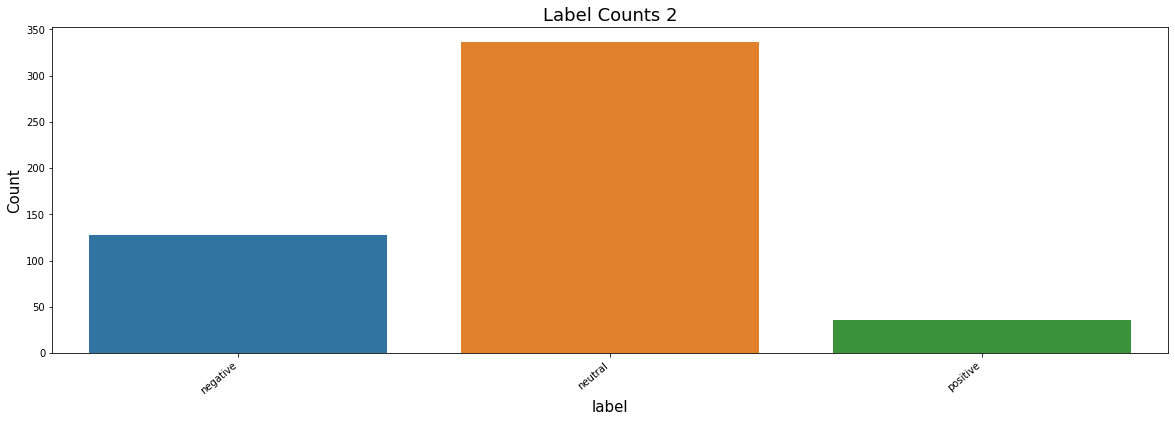

In [27]:
label_2_counts = create_count_data(labels_2, "label")
print(label_2_counts)
create_barplot(label_2_counts, "label", "count", "Label Counts 2")

In [28]:
print(f"len labels 1: {len(labels_1)}")
print(f"len labels 2: {len(labels_2)}")

len labels 1: 491
len labels 2: 500


In [29]:
labels = labels_1
labels = labels.append(labels_2)
print(f"len label combined: {len(labels)}")
print(f"len label index: {labels.index.nunique()}")

len label combined: 991
len label index: 991


#### Merge labels

In [30]:
labeled_data = labels.merge(data, left_index = True, right_index = True, how = 'left')
print(labeled_data.shape)
labeled_data.head()

(991, 34)


,label,orig_selftext,text_clean_space,text_clean_punc_lower,len_clean,vader_neg,vader_neu,vader_pos,vader_compound,textblob_sentiment,textblob_objectivity,selftext,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,parent_id,score,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class,created_date,post_type,date
3605270,neutral,So much word salad!,So much word salad!,so much word salad,18,0.000,1.000,0.000,0.0000,0.200000,0.200000,So much word salad!,NaN,NaN,NaN,majorelle_blue,NaN,NaN,1561687965,t5_38unr,t3_c6djfn,t3_c6djfn,2,1571037655,0,0,es84xw0,The_Donald,NaN,NaN,NaN,2019-06-27,extant,2019-06-27
3844737,neutral,It's pronounced Milly - walk - ayyyy.,It's pronounced Milly - walk - ayyyy.,its pronounced milly walk ayyyy,33,0.000,1.000,0.000,0.0000,0.000000,0.000000,It's pronounced Milly - walk - ayyyy.,NaN,NaN,NaN,Badgermilk15,NaN,NaN,1561462608,t5_38unr,t3_c4vyhk,t1_eryud5t,1,1570896466,0,0,es01sy9,The_Donald,NaN,NaN,NaN,2019-06-25,extant,2019-06-25
4113392,negative,"#There are two kinds of people:\n\n**Criminals, and non-criminals**\n\nDemocrats support criminals. Many democrats themselves are criminals (looking at you Hillary). democrats want to have more crime, or to even ""legalize"" longstanding criminal acts. democrats want convicted felons voting. Democrats want more criminals coming into our country, and support criminal entry methods.\n\nIf you ask non-criminals about criminals they will say we should ""lock them up"". They think crime should be punished, and laws upheld.\n\nThat is pretty much the foundation of the political divide in the country right now.","#There are two kinds of people: **Criminals, and non-criminals** Democrats support criminals. Many democrats themselves are criminals (looking at you Hillary). democrats want to have more crime, or to even ""legalize"" longstanding criminal acts. democrats want convicted felons voting. Democrats want more criminals coming into our country, and support criminal entry methods. If you ask non-criminals about criminals they will say we should ""lock them up"". They think crime should be punished, and laws upheld. That is pretty much the foundation of the political divide in the country right now.",there are two kinds of people criminals and noncriminals democrats support criminals many democrats themselves are criminals looking at you hillary democrats want to have more crime or to even legalize longstanding criminal acts democrats want convicted felons voting democrats want more criminals coming into our country and support criminal entry methods if you ask noncriminals about criminals they will say we should lock them up they think crime should be punished and laws upheld that is pretty much the foundation of the political divide in the country right now,569,0.269,0.627,0.104,-0.9741,0.159524,0.492857,"#There are two kinds of people:\n\n**Criminals, and non-criminals**\n\nDemocrats support criminals. Many democrats themselves are criminals (looking at you Hillary). democrats want to have more crime, or to even ""legalize"" longstanding criminal acts. democrats want convicted felons voting. Democrats want more criminals coming into our country, and support criminal entry methods.\n\nIf you ask non-criminals about criminals they will say we should ""lock them up"". They think crime should be punished, and laws upheld.\n\nThat is pretty much the foundation of the political divide in the country right now.",NaN,NaN,NaN,Bulldog65,1776,NaN,1560527139,t5_38unr,t3_c0kjo4,t3_c0kjo4,12,1569900812,0,0,er5j7ce,The_Donald,NaN,NaN,MURICA,2019-06-14,extant,2019-06-14
3035067,neutral,She really is. ����,She really is.,she really is,14,0.000,1.000,0.000,0.0000,0.200000,0.200000,She really is. ����,NaN,NaN,NaN,InventorOfBacon,NaN,NaN,1563107088,t5_38unr,t3_ccyvg7,t1_etqixjw,6,1571987193,0,0,etqyjmz,The_Donald,NaN,NaN,NaN,2019-07-14,extant,2019-07-14
3038117,negative,"I know what you mean, but it is not up

### Distribution of sentiment scores by manual label category

Text(0.5, 1.0, 'Negative Labels: Vader Score')

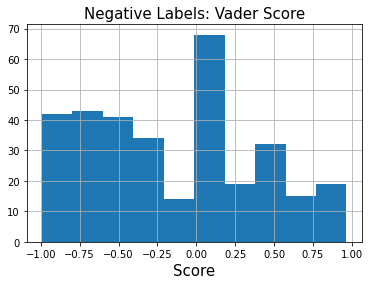

In [31]:
labeled_data[labeled_data["label"]=="negative"].hist(column="vader_compound")
plt.xlabel("Score", size=15)
plt.title("Negative Labels: Vader Score", size=15)


Text(0.5, 1.0, 'Negative Labels: Text Blob')

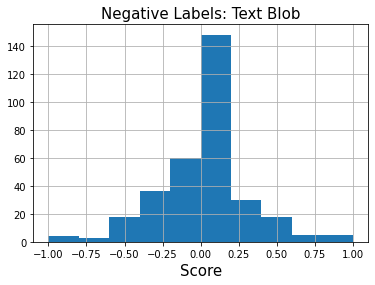

In [32]:
labeled_data[labeled_data["label"]=="negative"].hist(column="textblob_sentiment")
plt.xlabel("Score", size=15)
plt.title("Negative Labels: Text Blob", size=15)


Text(0.5, 1.0, 'Neutral Labels: Vader Score')

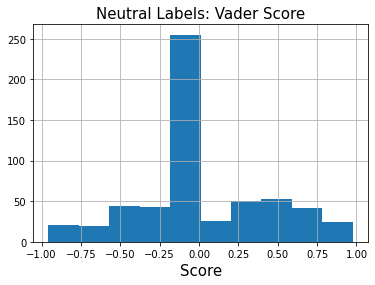

In [33]:
labeled_data[labeled_data["label"]=="neutral"].hist(column="vader_compound")
plt.xlabel("Score", size=15)
plt.title("Neutral Labels: Vader Score", size=15)

(-1.0, 1.0)

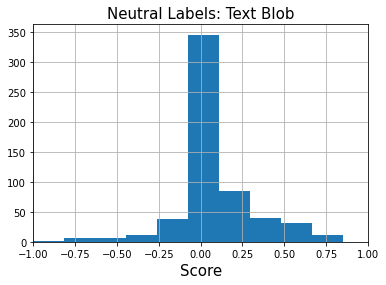

In [34]:
labeled_data[labeled_data["label"]=="neutral"].hist(column="textblob_sentiment")
plt.xlabel("Score", size=15)
plt.title("Neutral Labels: Text Blob", size=15)
plt.xlim([-1.0, 1.0])

(-1.0, 1.0)

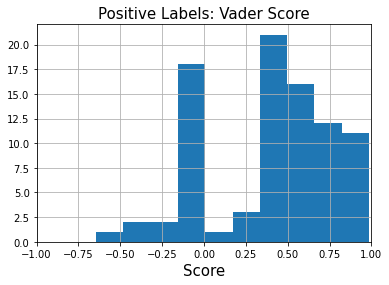

In [35]:
labeled_data[labeled_data["label"]=="positive"].hist(column="vader_compound")
plt.xlabel("Score", size=15)
plt.title("Positive Labels: Vader Score", size=15)
plt.xlim([-1.0, 1.0])

(-1.0, 1.0)

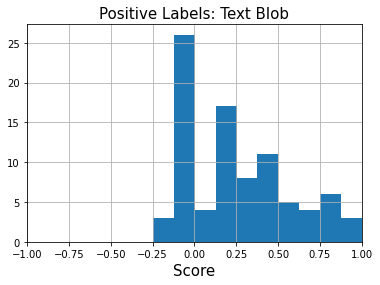

In [36]:
labeled_data[labeled_data["label"]=="positive"].hist(column="textblob_sentiment")
plt.xlabel("Score", size=15)
plt.title("Positive Labels: Text Blob", size=15)
plt.xlim([-1.0, 1.0])

### Threshold score and compute confusion matrix & evaluation metrics

In [37]:
neg_cutoff = -0.25
pos_cutoff = 0.25
labeled_data["VADER PRED_LABEL"] = np.where(labeled_data.vader_compound < neg_cutoff, 'negative',
                           np.where(labeled_data.vader_compound > pos_cutoff,'positive', 'neutral'))

labeled_data["TEXTBLOB PRED_LABEL"] = np.where(labeled_data.textblob_sentiment < neg_cutoff, 'negative',
                           np.where(labeled_data.textblob_sentiment > pos_cutoff,'positive', 'neutral'))

In [38]:
pd.crosstab(labeled_data["label"], labeled_data["VADER PRED_LABEL"], dropna=False)

VADER PRED_LABEL,negative,neutral,positive
label,,,
negative,155,90,82
neutral,117,301,159
positive,4,20,63


In [39]:
pd.crosstab(labeled_data["label"], labeled_data["TEXTBLOB PRED_LABEL"], dropna=False)

TEXTBLOB PRED_LABEL,negative,neutral,positive
label,,,
negative,46,237,44
neutral,27,456,94
positive,0,50,37


In [40]:
v_confusion = confusion_matrix(labeled_data["label"].values, labeled_data["VADER PRED_LABEL"].values)
print('VADER Confusion Matrix\n')
print(v_confusion)

VADER Confusion Matrix

[[155  90  82]
 [117 301 159]
 [  4  20  63]]


In [41]:
t_confusion = confusion_matrix(labeled_data["label"].values, labeled_data["TEXTBLOB PRED_LABEL"].values)
print('TEXTBLOB Confusion Matrix\n')
print(t_confusion)

TEXTBLOB Confusion Matrix

[[ 46 237  44]
 [ 27 456  94]
 [  0  50  37]]



Accuracy: 0.52

Weighted Precision: 0.63
Weighted Recall: 0.52
Weighted F1-score: 0.55


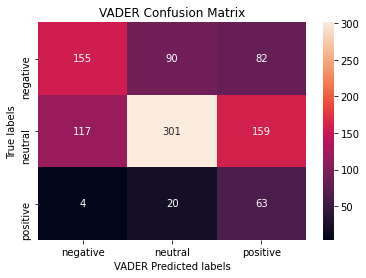

In [42]:
y_test = labeled_data["label"].values
y_pred = labeled_data["VADER PRED_LABEL"].values
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

ax= plt.subplot()
sns.heatmap(v_confusion,annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('VADER Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('VADER Confusion Matrix'); 
ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive']);
ax.yaxis.set_ticklabels(['negative', 'neutral', 'positive']);


Accuracy: 0.54

Weighted Precision: 0.58
Weighted Recall: 0.54
Weighted F1-score: 0.50


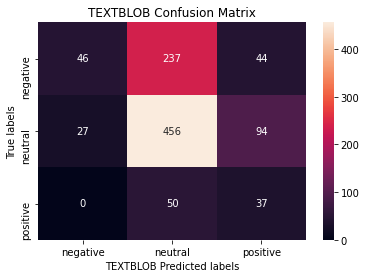

In [43]:
y_test = labeled_data["label"].values
y_pred = labeled_data["TEXTBLOB PRED_LABEL"].values
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

ax= plt.subplot()
sns.heatmap(t_confusion,annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('TEXTBLOB Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('TEXTBLOB Confusion Matrix'); 
ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive']);
ax.yaxis.set_ticklabels(['negative', 'neutral', 'positive']);

### Find examples of misclassifications

In [47]:
label_restricted = labeled_data[['text_clean_space', 'label',
                                 'vader_compound', 'VADER PRED_LABEL',
                                 'textblob_sentiment', 'TEXTBLOB PRED_LABEL']]

In [49]:
label_restricted[label_restricted.index==3038117]

,text_clean_space,label,vader_compound,VADER PRED_LABEL,textblob_sentiment,TEXTBLOB PRED_LABEL
3038117,"I know what you mean, but it is not up to the bank to ""increase the wages"". The wages will increase automatically if the system is operating in a true free market economy. It has been well established for centuries. If you game the system like the elites/bankers/communist on the upper side and the poor/free loading on the other side then this is what you get.",negative,0.9636,positive,-0.014583,neutral


In [54]:
label_restricted[label_restricted.index==3986414]

,text_clean_space,label,vader_compound,VADER PRED_LABEL,textblob_sentiment,TEXTBLOB PRED_LABEL
3986414,"Legend has it, only gay kids can read that",negative,0.0,neutral,0.208333,neutral


In [56]:
label_restricted[label_restricted.index==3966928]

,text_clean_space,label,vader_compound,VADER PRED_LABEL,textblob_sentiment,TEXTBLOB PRED_LABEL
3966928,It was in The Sun. It must be true.,neutral,0.4215,positive,0.35,positive


In [57]:
label_restricted[label_restricted.index==2693308]

,text_clean_space,label,vader_compound,VADER PRED_LABEL,textblob_sentiment,TEXTBLOB PRED_LABEL
2693308,"Damn, I want to be oppressed. Give me some of that oppression!",neutral,-0.6996,negative,0.0,neutral


In [61]:
label_restricted[label_restricted.index.isin([2693308,3966928,3986414,3038117])]

,text_clean_space,label,vader_compound,VADER PRED_LABEL,textblob_sentiment,TEXTBLOB PRED_LABEL
3038117,"I know what you mean, but it is not up to the bank to ""increase the wages"". The wages will increase automatically if the system is operating in a true free market economy. It has been well established for centuries. If you game the system like the elites/bankers/communist on the upper side and the poor/free loading on the other side then this is what you get.",negative,0.9636,positive,-0.014583,neutral
3986414,"Legend has it, only gay kids can read that",negative,0.0000,neutral,0.208333,neutral
2693308,"Damn, I want to be oppressed. Give me some of that oppression!",neutral,-0.6996,negative,0.000000,neutral
3966928,It was in The Sun. It must be true.,neutral,0.4215,positive,0.350000,positive


In [55]:
label_restricted.tail(20)

,text_clean_space,label,vader_compound,VADER PRED_LABEL,textblob_sentiment,TEXTBLOB PRED_LABEL
3647774,Google and its climate cultists are the enemy of the American people.,neutral,-0.5423,negative,0.000000,neutral
3333468,#CLASS ACTION LAWSUIT,neutral,-0.2263,neutral,0.100000,neutral
2693308,"Damn, I want to be oppressed. Give me some of that oppression!",neutral,-0.6996,negative,0.000000,neutral
4220290,They are,neutral,0.0000,neutral,0.000000,neutral
3098451,"Thats how Trump ended up running, so I cant fault the guy for that.",neutral,0.3687,positive,0.000000,neutral
3029811,"The articles about it are all really disastrously written, as if they're trying to muddle what's really happening. Also, kinda funny that Bond leaving MI6 has *finally* resulted in a replacement 007 (at least temporarily). I'm guessing he comes back to MI6 and is still 007 by the end - pretty sure Bond ""goes rogue"" and leaves MI6 in every single Daniel Craig Bond movie.",neutral,0.7968,positive,0.014286,neutral
3966928,It was in The Sun. It must be true.,neutral,0.4215,positive,0.350000,positive
2955698,"It's to justify the imposition of massive carbon taxes. People aren't going to just accept them, so they want to scare us into accepting them as necessary.",neutral,0.3774,positive,0.000000,neutral
3259175,Agenda Free TV livestream https://youtu.be/dKrSNAXeWeY Sounds like not much is known at this time about what happened exactly. Interesting for sure.,neutral,0.8689,positive,0.325000,positive
3446071,Do you actually want to know? Because its more than you think.,neutral,0.0772,neutral,0.250000,neutral
